# Univariate results, basic feature engineering

In this notebook the following approaches are implemented:
- no feature engineering
- minmax scaling
- differenecing
- differencing + log transforms

In [1]:
from one_dimensional_time_series_forecasting import time_series_prediction, hit_rate
import pandas as pd

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# interactive figures
%matplotlib widget 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from tabulate import tabulate


2022-05-08 17:32:26.125486: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-08 17:32:26.125505: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import sys
import warnings
import os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

# 1. Baseline: no feature engineering

## 1.1 S&P 500

Date         Open         High          Low        Close  \
0     2014-01-23  1842.290039  1842.290039  1820.060059  1828.459961   
1     2014-01-24  1826.959961  1826.959961  1790.290039  1790.290039   
2     2014-01-27  1791.030029  1795.979980  1772.880005  1781.560059   
3     2014-01-28  1783.000000  1793.869995  1779.489990  1792.500000   
4     2014-01-29  1790.150024  1790.150024  1770.449951  1774.199951   
...          ...          ...          ...          ...          ...   
1995  2021-12-23  4703.959961  4740.740234  4703.959961  4725.790039   
1996  2021-12-27  4733.990234  4791.490234  4733.990234  4791.189941   
1997  2021-12-28  4795.490234  4807.020020  4780.040039  4786.350098   
1998  2021-12-29  4788.640137  4804.060059  4778.080078  4793.060059   
1999  2021-12-30  4794.229980  4808.930176  4775.330078  4778.729980   

          Volume  
0     3972250000  
1     4618450000  
2     4045200000  
3     3437830000  
4     3964020000  
...          ...  
1995  2194630000  
1996  2264120000  
1997  2217050000  
1998  2369370000  
1999  2390990000  

[2000 rows x 6 columns]

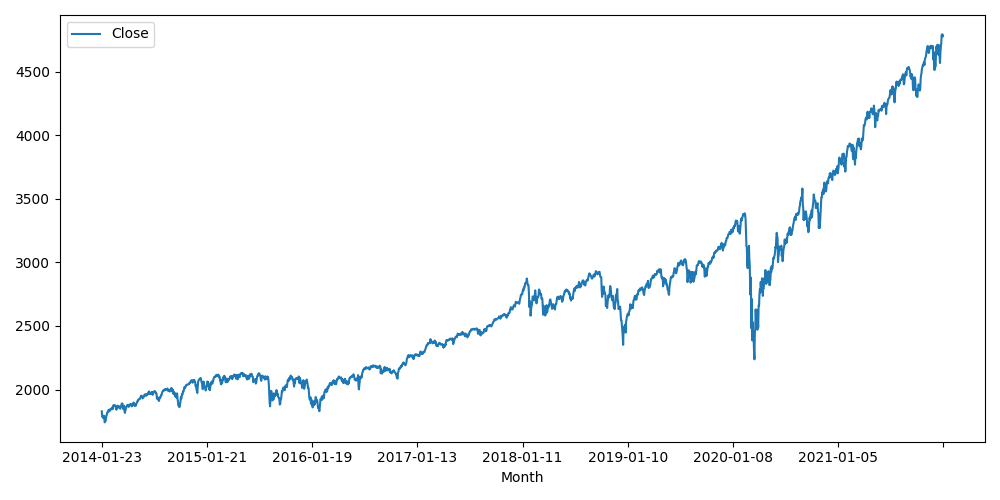

In [3]:
# import some data
df = pd.read_csv('./test_data/S&P500_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
df.drop(labels='Adj Close',axis=1,inplace=True)
df.plot(x='Date',y='Close',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
plt.tight_layout()
display(df)

Trial 20 Complete [00h 00m 28s]
val_loss: 0.002069193567149341

Best val_loss So Far: 0.0008542558643966913
Total elapsed time: 00h 09m 32s
INFO:tensorflow:Oracle triggered exit
Best LSTM hyperparamteres: <keras_tuner.engine.hyperparameters.HyperParameters object at 0x7f23a8732fa0>
Epoch 251: early stopping
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 240)           232320    
                                                                 
 lstm_5 (LSTM)               (None, 10, 240)           461760    
                                                                 
 lstm_6 (LSTM)               (None, 176)               293568    
                                                                 
 dense_1 (Dense)             (None, 1)                 177       
                                                                 
Total par

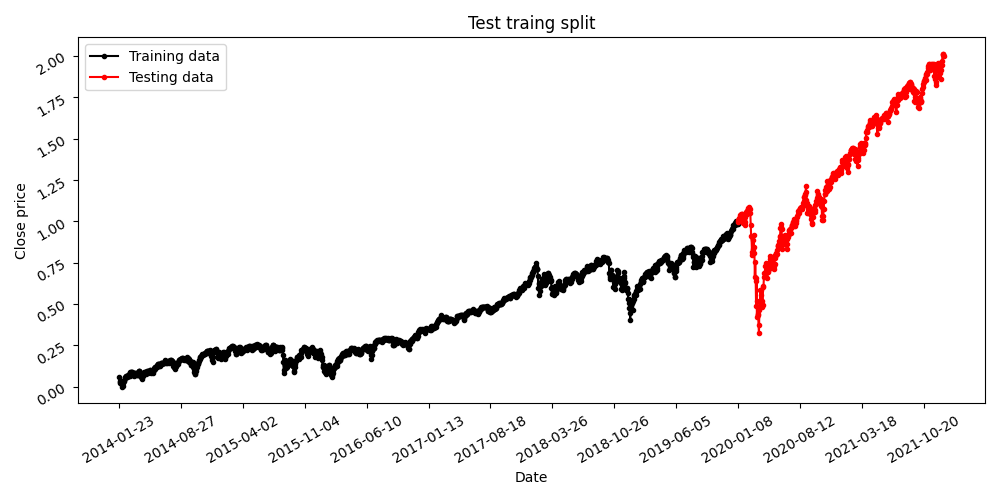

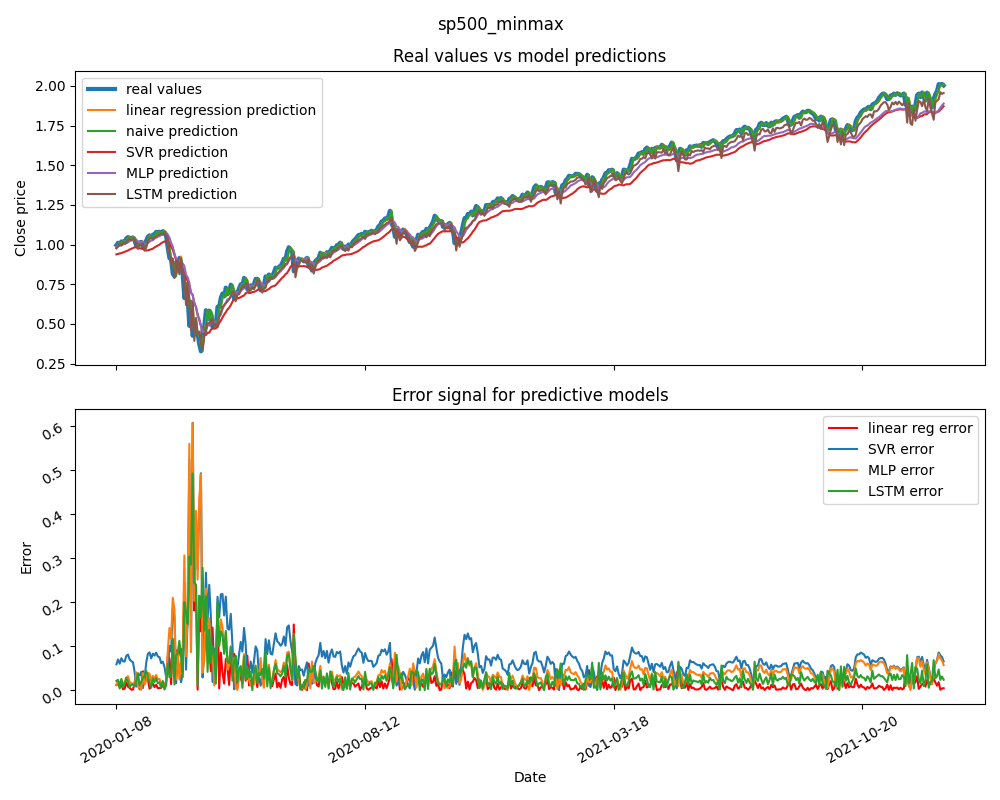

In [4]:
# some forecasting parameters
window_length = 10
split = 500

# scaled input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(df['Close'][0:-split].to_numpy().reshape(-1,1)).flatten()
scaled_test_data = scaler.transform(df['Close'][-split:].to_numpy().reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction('sp500_minmax',df['Date'],scaled_input_data,window_length,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
blah.support_vector_machine(model_tunning=True)
blah.neural_net_mlp(model_tunning=True)
blah.lstm(model_tunning=True, verbose=0)
blah.naive_model()

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# view final results
blah.conclusion()

### walk forward validation results

In [5]:
financial_asset = 'sp500'
mapping = {'LinearReg':blah.linear_regression_model,
            'svr':blah.svr_model,
            'MLP':blah.mlp_model,
            'LSTM':blah.lstm_model}
feat_engineering = 'minmax'

# store evaulation results for different models
model_results = []

# apply walkforward for all models
for model_name in mapping.keys():

    # retrieve model
    model = mapping[model_name]

    # apply walk forward and save results
    train_len = 225
    test_len = 25
    df_walk_forward, df, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,train_len=train_len,test_len=test_len,train_frequency=10)

    # wrangle results
    
    # plots
    df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
    
    fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
    ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
    ax[0].set_ylabel('Close')

    ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
    ax[1].set_title('Walk forward error through time')
    ax[1].set_xlabel('Dates')
    ax[1].legend()

    max = df_walk_forward.shape[0]
    ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
    ax[1].tick_params(rotation=30)
    ax[1].set_ylabel('Error')
    ax[1].set_xlabel('Date')
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{financial_asset}_{model_name}_{feat_engineering}_wf.png',facecolor='w')
    plt.close()

    # tables 
    model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

# place into df
df_conclusion_wf = pd.DataFrame.from_records(model_results)
df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_results_summary_wf.csv')
latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
with open(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_latex_table_wf.txt',"w") as my_latex_table:
    my_latex_table.write(latex_table)


Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 47.44 %
Confusion matrix:
[[332 473]
 [460 510]]
MAPE: 0.02908425201661828
RMSE:  0.021704337572081945
MAE:  0.01448485878330776
Directional Accuracy:  0.474366197183098

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 50.65 %
Confusion matrix:
[[416 389]
 [487 483]]
MAPE: 0.2406881923539872
RMSE:  0.12996751049402516
MAE:  0.11248230079594174
Directional Accuracy:  0.5064788732394366


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 49.41 %
Confusion matrix:
[[287 518]
 [380 590]]
MAPE: 0.039249137722032756
RMSE:  0.03241137772064997
MAE:  0.020639441479123003
Directional Accuracy:  0.49408450704225

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Taking 71 walks during walk forward validation
walk 0
Retraining model.
7/7 [==============================] - 0s 18ms/step - loss: 9.5432e-05
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
7/7 [==============================] - 0s 19ms/step - loss: 2.0745e-04
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
7/7 [==============================] - 0s 25ms/step - loss: 1.6100e-04
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
7/7 [==============================] - 0s 22ms/step - loss: 6.2152e-05
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
7/7 [==============================] - 0s 20ms/step - loss: 8.7263e-04
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
7/7 [==============================] - 0s 15ms/step - loss: 0.0017
walk 51
walk 52
walk 53
w

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## 1.2 Gold price

Date         Open         High          Low        Close  Volume
0     2014-01-21  1256.400024  1257.500000  1240.000000  1242.300049     224
1     2014-01-22  1241.699951  1242.000000  1239.000000  1239.000000      58
2     2014-01-23  1235.199951  1264.199951  1235.199951  1262.599976      40
3     2014-01-24  1258.300049  1269.400024  1258.300049  1264.500000      38
4     2014-01-27  1259.800049  1264.400024  1254.400024  1263.599976      92
...          ...          ...          ...          ...          ...     ...
1995  2021-12-23  1806.000000  1811.199951  1800.800049  1811.199951     193
1996  2021-12-27  1810.000000  1812.099976  1807.000000  1808.099976     150
1997  2021-12-28  1812.000000  1818.000000  1805.500000  1810.199951     146
1998  2021-12-29  1803.199951  1805.099976  1791.400024  1805.099976     623
1999  2021-12-30  1801.699951  1816.000000  1796.000000  1812.699951     306

[2000 rows x 6 columns]

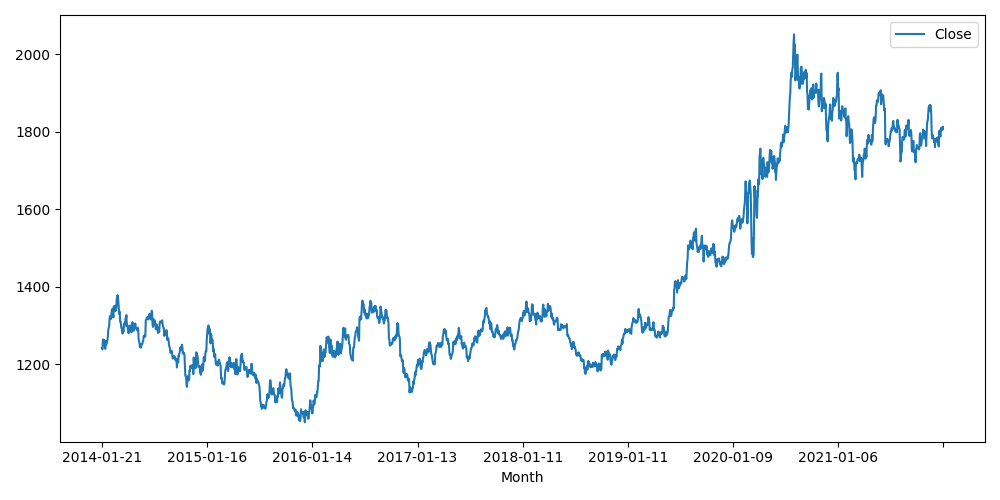

In [6]:
# import some data
df = pd.read_csv('./test_data/Gold_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
df.drop(labels='Adj Close',axis=1,inplace=True)
df.plot(x='Date',y='Close',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
plt.tight_layout()
display(df)

Trial 20 Complete [00h 00m 39s]
val_loss: 0.03718313863500953

Best val_loss So Far: 0.0028584737330675123
Total elapsed time: 00h 13m 46s
INFO:tensorflow:Oracle triggered exit
Best LSTM hyperparamteres: <keras_tuner.engine.hyperparameters.HyperParameters object at 0x7f23a1c2cee0>
Epoch 1/2000
12/12 [==============================] - 3s 64ms/step - loss: 0.0893
Epoch 2/2000
12/12 [==============================] - 1s 65ms/step - loss: 0.0144
Epoch 3/2000
12/12 [==============================] - 1s 65ms/step - loss: 0.0056
Epoch 4/2000
12/12 [==============================] - 1s 65ms/step - loss: 0.0025
Epoch 5/2000
12/12 [==============================] - 1s 63ms/step - loss: 0.0023
Epoch 6/2000
12/12 [==============================] - 1s 61ms/step - loss: 0.0023
Epoch 7/2000
12/12 [==============================] - 1s 64ms/step - loss: 0.0021
Epoch 8/2000
12/12 [==============================] - 1s 70ms/step - loss: 0.0021
Epoch 9/2000
12/12 [==============================] - 1s 64ms/

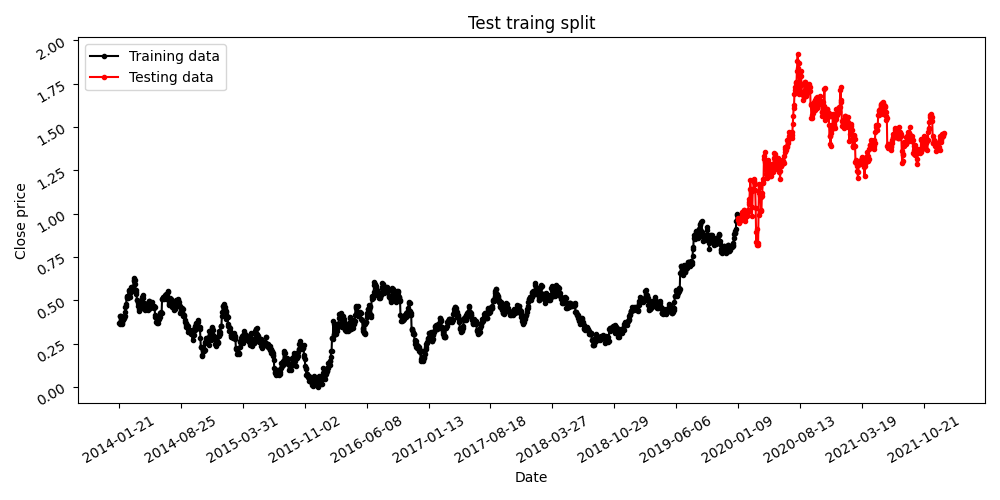

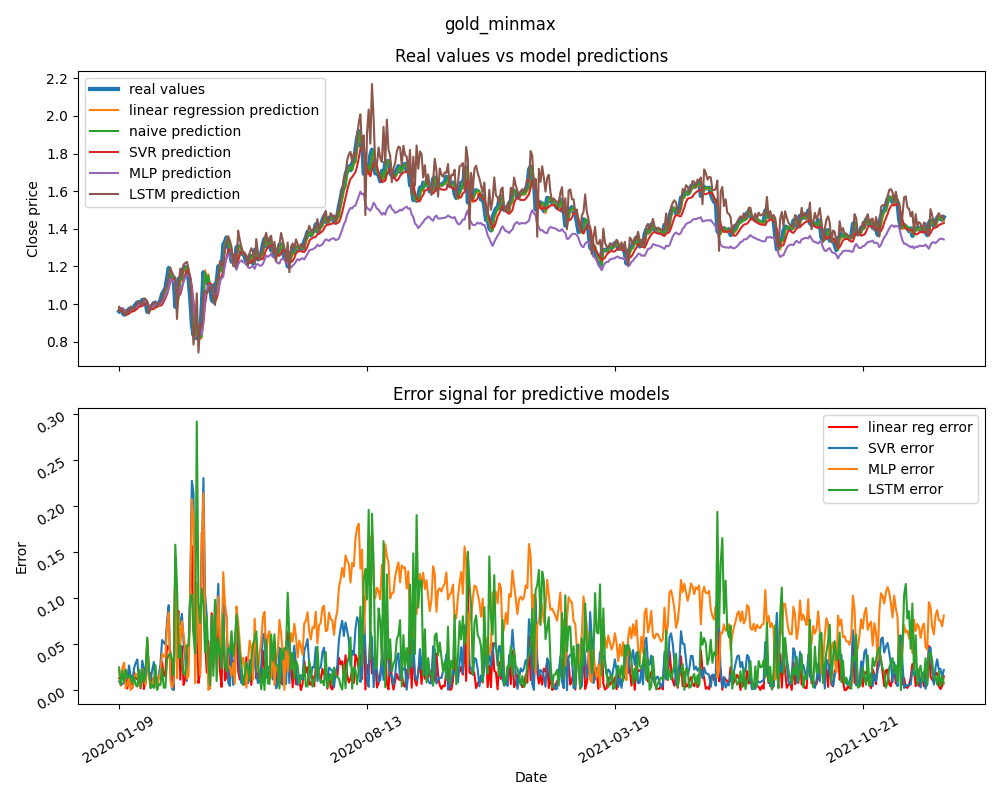

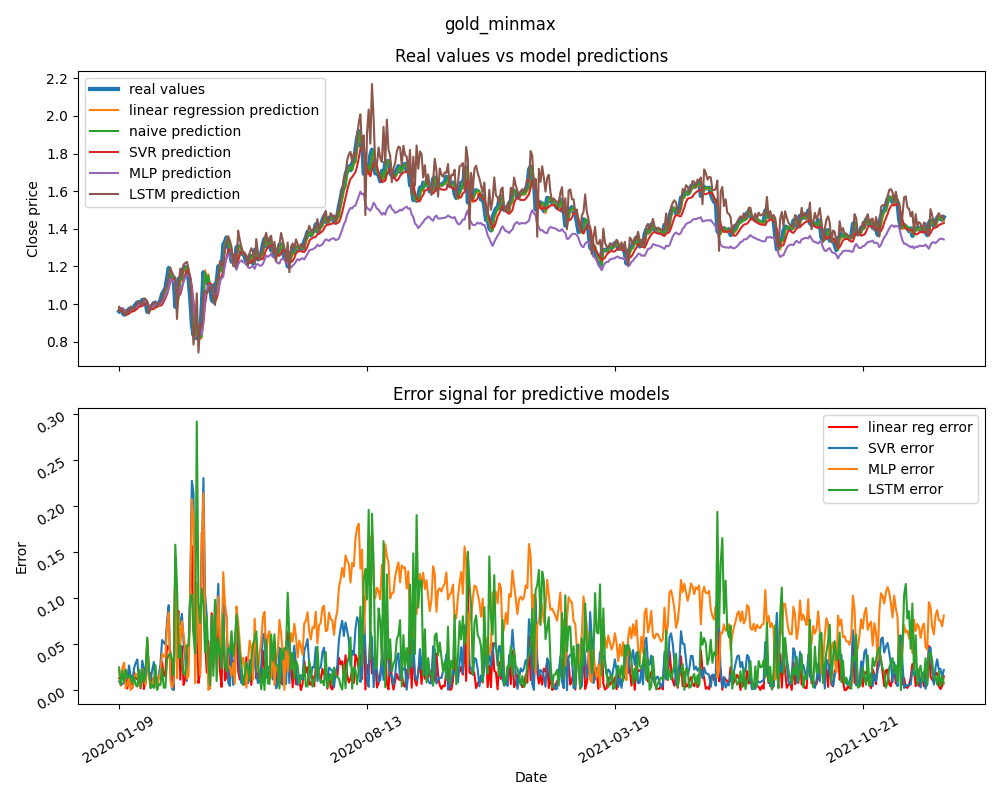

In [7]:
# some forecasting parameters
window_length = 10
split = 500

# input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(df['Close'][0:-split].to_numpy().reshape(-1,1)).flatten()
scaled_test_data = scaler.transform(df['Close'][-split:].to_numpy().reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction('gold_minmax',df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
blah.support_vector_machine(model_tunning=True)
blah.neural_net_mlp(model_tunning=True)
blah.lstm(model_tunning=True)
blah.naive_model()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# view final results
blah.conclusion()

In [8]:
financial_asset = 'gold'
mapping = {'LinearReg':blah.linear_regression_model,
            'svr':blah.svr_model,
            'MLP':blah.mlp_model,
            'LSTM':blah.lstm_model}
feat_engineering = 'minmax'

# store evaulation results for different models
model_results = []

# apply walkforward for all models
for model_name in mapping.keys():

    # retrieve model
    model = mapping[model_name]

    # apply walk forward and save results
    train_len = 225
    test_len = 25
    df_walk_forward, df, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,train_len=train_len,test_len=test_len,train_frequency=10)

    # wrangle results
    
    # plots
    df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
    
    fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
    ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
    ax[0].set_ylabel('Close')

    ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
    ax[1].set_title('Walk forward error through time')
    ax[1].set_xlabel('Dates')
    ax[1].legend()

    max = df_walk_forward.shape[0]
    ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
    ax[1].tick_params(rotation=30)
    ax[1].set_ylabel('Error')
    ax[1].set_xlabel('Date')
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{financial_asset}_{model_name}_{feat_engineering}_wf.png',facecolor='w')
    plt.close()

    # tables 
    model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

# place into df
df_conclusion_wf = pd.DataFrame.from_records(model_results)
df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_results_summary_wf.csv')
latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
with open(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_latex_table_wf.txt',"w") as my_latex_table:
    my_latex_table.write(latex_table)


Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 48.56 %
Confusion matrix:
[[401 458]
 [455 461]]
MAPE: 163990743788.97028
RMSE:  0.027662713944659665
MAE:  0.01927639352673661
Directional Accuracy:  0.4856338028169014

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 49.52 %
Confusion matrix:
[[404 455]
 [441 475]]
MAPE: 266770607178.92917
RMSE:  0.07278550222308258
MAE:  0.0534512451885849
Directional Accuracy:  0.4952112676056338


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 49.07 %
Confusion matrix:
[[413 446]
 [458 458]]
MAPE: 109309534468.30714
RMSE:  0.07875697697225816
MAE:  0.04169114858020805
Directional Accuracy:  0.49070422535211267

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Taking 71 walks during walk forward validation
walk 0
Retraining model.
7/7 [==============================] - 0s 26ms/step - loss: 4.5995e-04
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
7/7 [==============================] - 0s 26ms/step - loss: 4.4533e-04
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
7/7 [==============================] - 0s 25ms/step - loss: 0.0013
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
7/7 [==============================] - 0s 25ms/step - loss: 6.3164e-04
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
7/7 [==============================] - 0s 25ms/step - loss: 6.2176e-04
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
7/7 [==============================] - 0s 28ms/step - loss: 0.0054
walk 51
walk 52
walk 53
walk 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## 1.3 USD / EUR exchange rate

Date      Open      High       Low     Close  Volume
0     2014-04-29  1.385291  1.387900  1.380741  1.385291       0
1     2014-04-30  1.381387  1.387700  1.378660  1.381368       0
2     2014-05-01  1.386866  1.389101  1.386399  1.386924       0
3     2014-05-02  1.387097  1.387099  1.381349  1.387097       0
4     2014-05-05  1.387270  1.388800  1.386597  1.387270       0
...          ...       ...       ...       ...       ...     ...
1995  2021-12-24  1.132464  1.134430  1.130838  1.132734       0
1996  2021-12-27  1.132387  1.133500  1.130416  1.132426       0
1997  2021-12-28  1.132978  1.133600  1.129038  1.133003       0
1998  2021-12-29  1.131337  1.137001  1.127536  1.131478       0
1999  2021-12-30  1.135976  1.135976  1.130071  1.136015       0

[2000 rows x 6 columns]

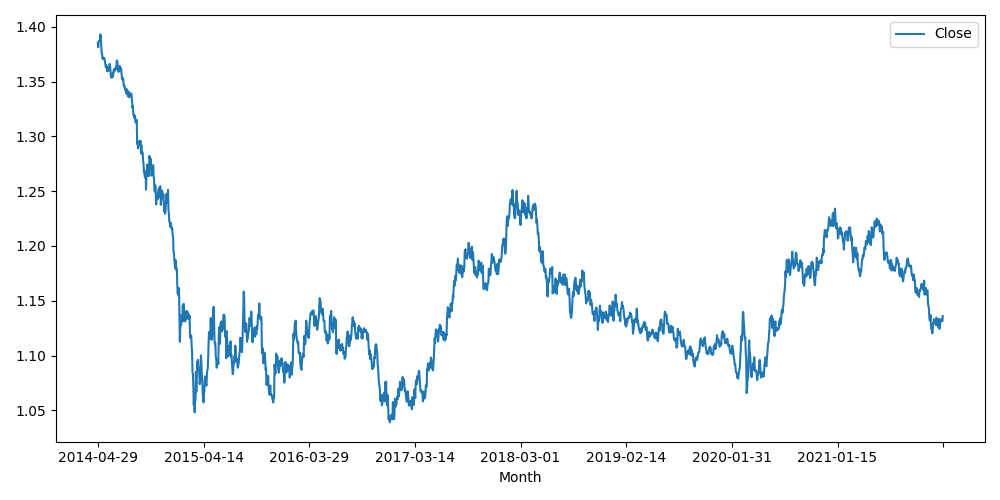

In [9]:
# import some data
df = pd.read_csv('./test_data/EurUsd_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
df.drop(labels='Adj Close',axis=1,inplace=True)
df.plot(x='Date',y='Close',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
plt.tight_layout()
display(df)

Trial 20 Complete [00h 00m 28s]
val_loss: 0.0003404049668461084

Best val_loss So Far: 0.0002801951253786683
Total elapsed time: 00h 08m 59s
INFO:tensorflow:Oracle triggered exit
Best LSTM hyperparamteres: <keras_tuner.engine.hyperparameters.HyperParameters object at 0x7f24cba4d610>
Epoch 1/2000
12/12 [==============================] - 1s 19ms/step - loss: 0.1290
Epoch 2/2000
12/12 [==============================] - 0s 18ms/step - loss: 0.0400
Epoch 3/2000
12/12 [==============================] - 0s 18ms/step - loss: 0.0088
Epoch 4/2000
12/12 [==============================] - 0s 18ms/step - loss: 0.0035
Epoch 5/2000
12/12 [==============================] - 0s 18ms/step - loss: 0.0019
Epoch 6/2000
12/12 [==============================] - 0s 18ms/step - loss: 0.0015
Epoch 7/2000
12/12 [==============================] - 0s 18ms/step - loss: 0.0015
Epoch 8/2000
12/12 [==============================] - 0s 18ms/step - loss: 0.0013
Epoch 9/2000
12/12 [==============================] - 0s 18m

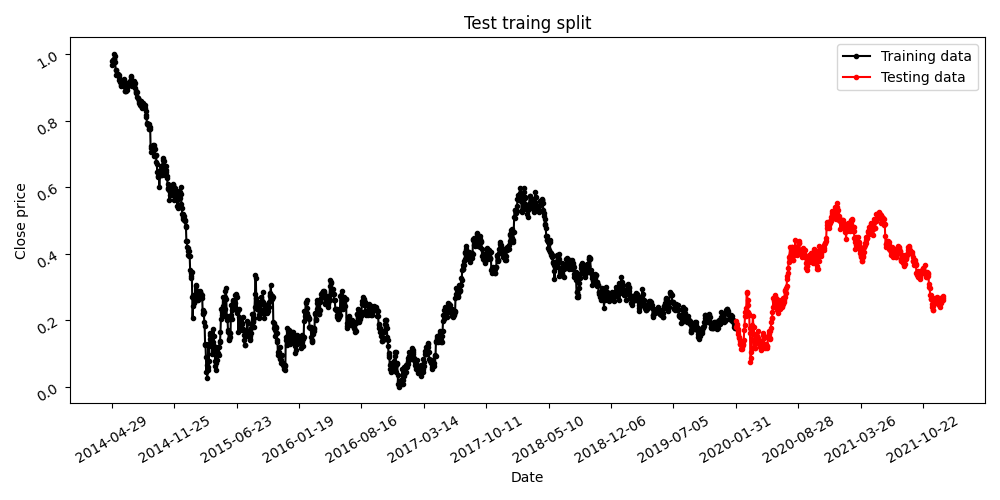

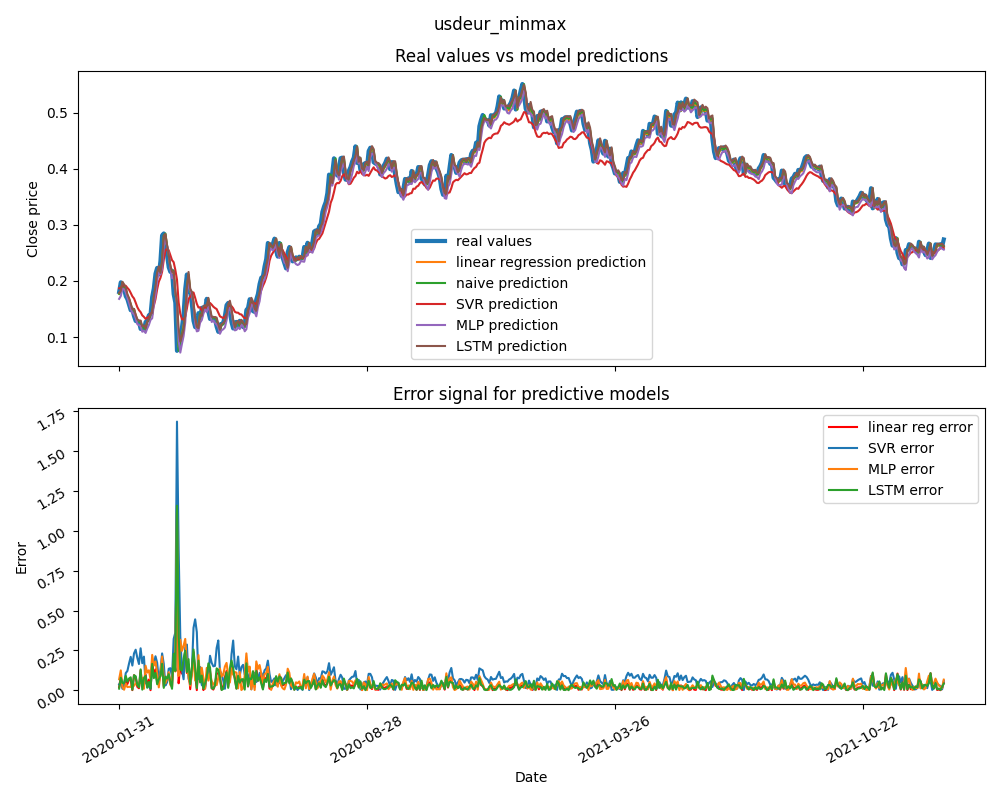

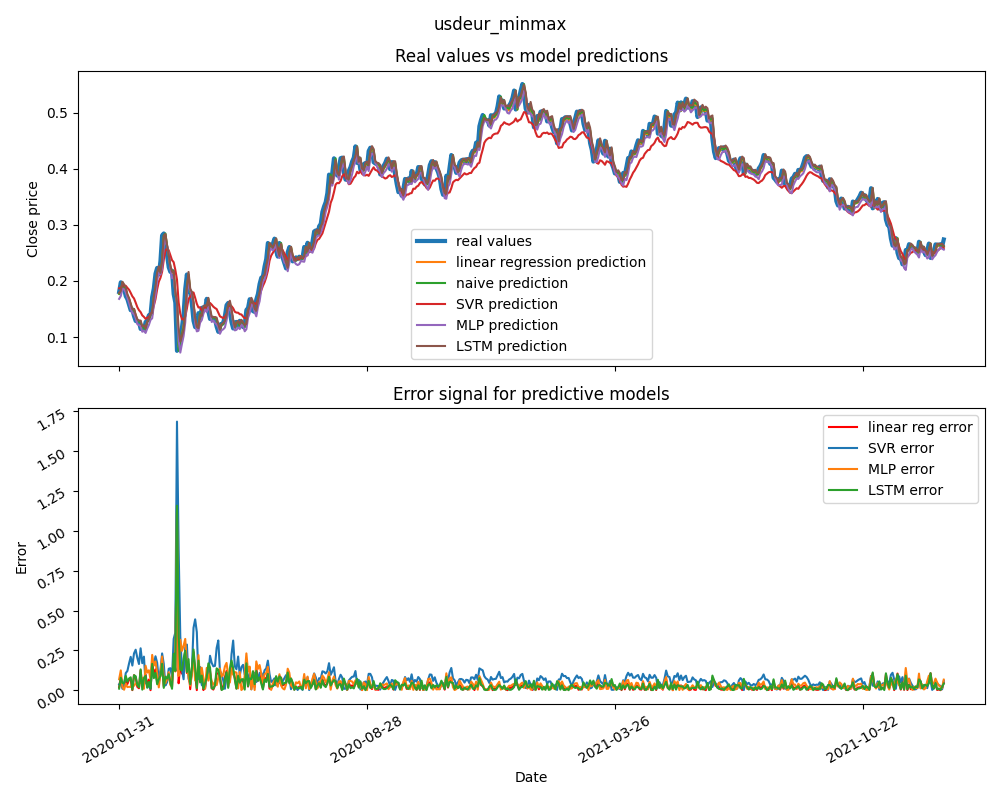

In [10]:
# some forecasting parameters
window_length = 10
split = 500

# input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(df['Close'][0:-split].to_numpy().reshape(-1,1)).flatten()
scaled_test_data = scaler.transform(df['Close'][-split:].to_numpy().reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction('usdeur_minmax',df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
blah.support_vector_machine(model_tunning=True)
blah.neural_net_mlp(model_tunning=True)
blah.lstm(model_tunning=True)
blah.naive_model()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# view final results
blah.conclusion()

In [11]:
financial_asset = 'usdeur'
mapping = {'LinearReg':blah.linear_regression_model,
            'svr':blah.svr_model,
            'MLP':blah.mlp_model,
            'LSTM':blah.lstm_model}
feat_engineering = 'minmax'

# store evaulation results for different models
model_results = []

# apply walkforward for all models
for model_name in mapping.keys():

    # retrieve model
    model = mapping[model_name]

    # apply walk forward and save results
    train_len = 225
    test_len = 25
    df_walk_forward, df, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,train_len=train_len,test_len=test_len,train_frequency=10)

    # wrangle results
    
    # plots
    df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
    
    fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
    ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
    ax[0].set_ylabel('Close')

    ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
    ax[1].set_title('Walk forward error through time')
    ax[1].set_xlabel('Dates')
    ax[1].legend()

    max = df_walk_forward.shape[0]
    ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
    ax[1].tick_params(rotation=30)
    ax[1].set_ylabel('Error')
    ax[1].set_xlabel('Date')
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{financial_asset}_{model_name}_{feat_engineering}_wf.png',facecolor='w')
    plt.close()

    # tables 
    model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

# place into df
df_conclusion_wf = pd.DataFrame.from_records(model_results)
df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_results_summary_wf.csv')
latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
with open(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_latex_table_wf.txt',"w") as my_latex_table:
    my_latex_table.write(latex_table)


Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 49.8 %
Confusion matrix:
[[439 456]
 [435 445]]
MAPE: 32365363743.07812
RMSE:  0.016672744056125486
MAE:  0.012263011022255141
Directional Accuracy:  0.49802816901408453

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 47.72 %
Confusion matrix:
[[490 405]
 [523 357]]
MAPE: 336520080942.6727
RMSE:  0.07729452650357768
MAE:  0.06121000547813255
Directional Accuracy:  0.4771830985915493


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 48.17 %
Confusion matrix:
[[446 449]
 [471 409]]
MAPE: 90763914057.72076
RMSE:  0.024419636876082132
MAE:  0.018118398240484324
Directional Accuracy:  0.4816901408450704

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Taking 71 walks during walk forward validation
walk 0
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0320
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
7/7 [==============================] - 0s 9ms/step - loss: 0.0116
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
7/7 [==============================] - 0s 11ms/step - loss: 0.0045
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
7/7 [==============================] - 0s 10ms/step - loss: 0.0049
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
7/7 [==============================] - 0s 12ms/step - loss: 0.0012
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
7/7 [==============================] - 0s 10ms/step - loss: 6.6116e-04
walk 51
walk 52
walk 53
walk 54
walk 55
wal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## 1.4 Crude Oil price

Date       Open       High        Low      Close  Volume
0     2014-01-22  95.199997  96.889999  95.120003  96.730003  252349
1     2014-01-23  96.690002  97.839996  96.410004  97.320000  274078
2     2014-01-24  97.370003  97.800003  96.250000  96.639999  239673
3     2014-01-27  96.900002  97.180000  95.209999  95.720001  235110
4     2014-01-28  95.660004  97.660004  95.629997  97.410004  206490
...          ...        ...        ...        ...        ...     ...
1995  2021-12-23  73.029999  73.949997  72.269997  73.790001  270223
1996  2021-12-27  73.379997  76.089996  72.570000  75.570000  268490
1997  2021-12-28  75.970001  76.919998  75.529999  75.980003  249728
1998  2021-12-29  76.040001  77.370003  75.360001  76.559998  283557
1999  2021-12-30  76.580002  77.440002  75.779999  76.989998  231163

[2000 rows x 6 columns]

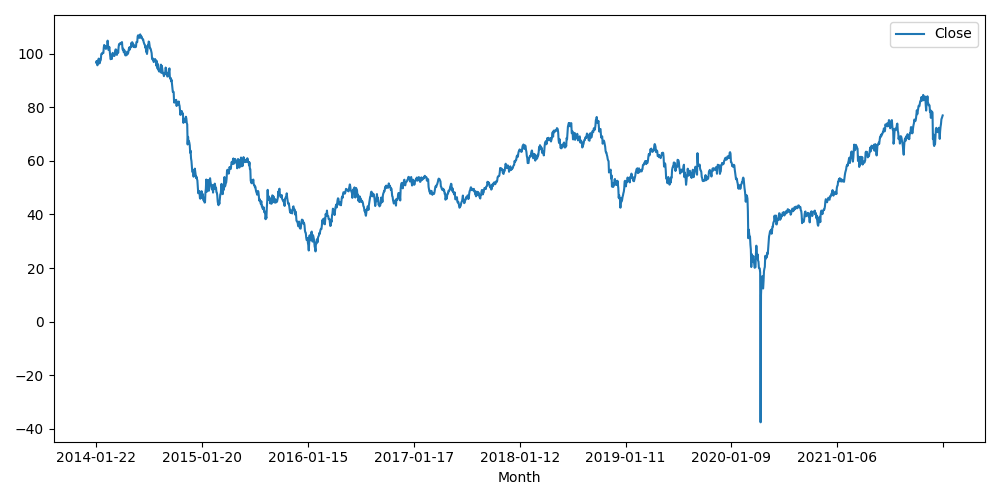

In [12]:
# import some data
df = pd.read_csv('./test_data/CrudeOil_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
df.drop(labels='Adj Close',axis=1,inplace=True)
df.plot(x='Date',y='Close',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
plt.tight_layout()
display(df)

Trial 20 Complete [00h 00m 38s]
val_loss: 0.0008637828985229134

Best val_loss So Far: 0.0006739945732988417
Total elapsed time: 00h 09m 55s
INFO:tensorflow:Oracle triggered exit
Best LSTM hyperparamteres: <keras_tuner.engine.hyperparameters.HyperParameters object at 0x7f23a1ed8370>
Epoch 1/2000
12/12 [==============================] - 2s 31ms/step - loss: 0.8055
Epoch 2/2000
12/12 [==============================] - 0s 29ms/step - loss: 0.0768
Epoch 3/2000
12/12 [==============================] - 0s 27ms/step - loss: 0.0293
Epoch 4/2000
12/12 [==============================] - 0s 26ms/step - loss: 0.0053
Epoch 5/2000
12/12 [==============================] - 0s 26ms/step - loss: 0.0024
Epoch 6/2000
12/12 [==============================] - 0s 26ms/step - loss: 0.0015
Epoch 7/2000
12/12 [==============================] - 0s 26ms/step - loss: 0.0011
Epoch 8/2000
12/12 [==============================] - 0s 26ms/step - loss: 0.0011
Epoch 9/2000
12/12 [==============================] - 0s 26m

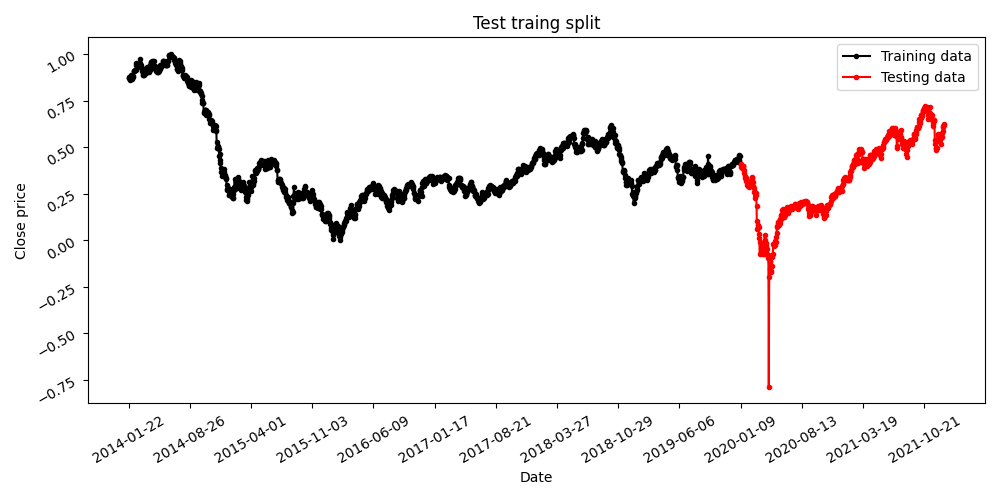

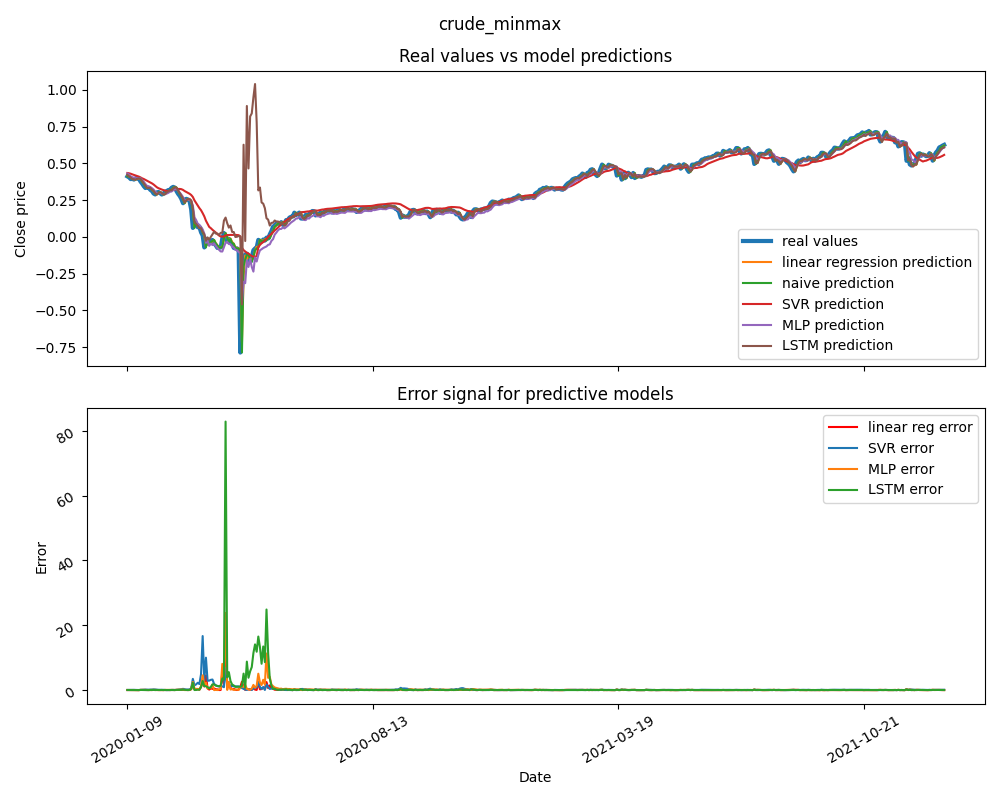

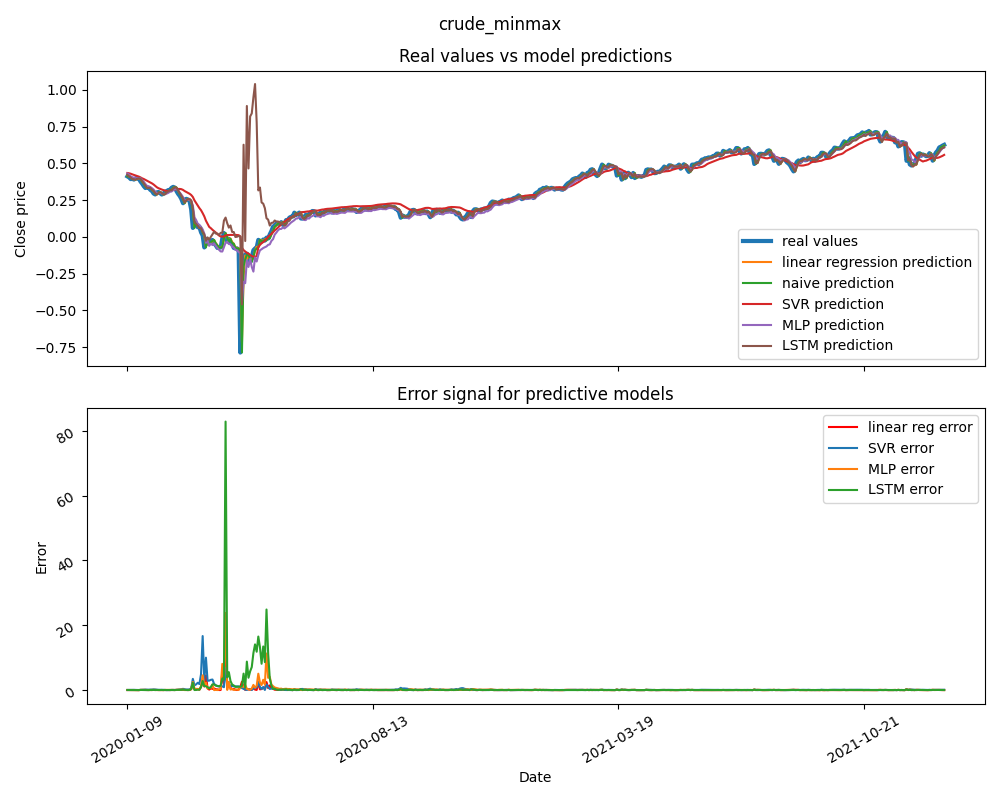

In [13]:
# some forecasting parameters
window_length = 10
split = 500

# input data
scaler = MinMaxScaler()
scaled_training_data = scaler.fit_transform(df['Close'][0:-split].to_numpy().reshape(-1,1)).flatten()
scaled_test_data = scaler.transform(df['Close'][-split:].to_numpy().reshape(-1,1)).flatten()
scaled_input_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction('crude_minmax',df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Close price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
blah.support_vector_machine(model_tunning=True)
blah.neural_net_mlp(model_tunning=True)
blah.lstm(model_tunning=True)
blah.naive_model()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# tabulate results nicely
blah.collect_results()

# visualize results
blah.vis_results_time_series(ylabel='Close price',second_plot='error')

# view final results
blah.conclusion()

In [14]:
financial_asset = 'CrudeOil'
mapping = {'LinearReg':blah.linear_regression_model,
            'svr':blah.svr_model,
            'MLP':blah.mlp_model,
            'LSTM':blah.lstm_model}
feat_engineering = 'minmax'

# store evaulation results for different models
model_results = []

# apply walkforward for all models
for model_name in mapping.keys():

    # retrieve model
    model = mapping[model_name]

    # apply walk forward and save results
    train_len = 225
    test_len = 25
    df_walk_forward, df, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,train_len=train_len,test_len=test_len,train_frequency=10)

    # wrangle results
    
    # plots
    df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
    
    fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
    ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
    ax[0].set_ylabel('Close')

    ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
    ax[1].set_title('Walk forward error through time')
    ax[1].set_xlabel('Dates')
    ax[1].legend()

    max = df_walk_forward.shape[0]
    ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
    ax[1].tick_params(rotation=30)
    ax[1].set_ylabel('Error')
    ax[1].set_xlabel('Date')
    plt.tight_layout()
    plt.savefig(f'./results/univariate_single_step_ahead/{financial_asset}_{model_name}_{feat_engineering}_wf.png',facecolor='w')
    plt.close()

    # tables 
    model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

# place into df
df_conclusion_wf = pd.DataFrame.from_records(model_results)
df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_results_summary_wf.csv')
latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
with open(f'./results/univariate_single_step_ahead/{financial_asset}_{feat_engineering}_latex_table_wf.txt',"w") as my_latex_table:
    my_latex_table.write(latex_table)


Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 49.41 %
Confusion matrix:
[[380 453]
 [445 497]]
MAPE: 47270946671.6287
RMSE:  0.029471807137044604
MAE:  0.016244943768718396
Directional Accuracy:  0.49408450704225354

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 50.99 %
Confusion matrix:
[[448 385]
 [485 457]]
MAPE: 470432362242.0079
RMSE:  0.13947866009321222
MAE:  0.10078381097160591
Directional Accuracy:  0.5098591549295775


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Taking 71 walks during walk forward validation
walk 0
Retraining model.
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
walk 51
walk 52
walk 53
walk 54
walk 55
walk 56
walk 57
walk 58
walk 59
walk 60
Retraining model.
walk 61
walk 62
walk 63
walk 64
walk 65
walk 66
walk 67
walk 68
walk 69
walk 70
Retraining model.
len pred:  1775
len history:  1775
len dates:  1775
Movement prediction accuracy: 50.48 %
Confusion matrix:
[[409 424]
 [455 487]]
MAPE: 1292044995.3209043
RMSE:  0.05207156681220486
MAE:  0.030152800349181864
Directional Accuracy:  0.5047887323943662

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Taking 71 walks during walk forward validation
walk 0
Retraining model.
7/7 [==============================] - 0s 14ms/step - loss: 0.1248
walk 1
walk 2
walk 3
walk 4
walk 5
walk 6
walk 7
walk 8
walk 9
walk 10
Retraining model.
7/7 [==============================] - 0s 16ms/step - loss: 0.1681
walk 11
walk 12
walk 13
walk 14
walk 15
walk 16
walk 17
walk 18
walk 19
walk 20
Retraining model.
7/7 [==============================] - 0s 16ms/step - loss: 0.0089
walk 21
walk 22
walk 23
walk 24
walk 25
walk 26
walk 27
walk 28
walk 29
walk 30
Retraining model.
7/7 [==============================] - 0s 19ms/step - loss: 0.0082
walk 31
walk 32
walk 33
walk 34
walk 35
walk 36
walk 37
walk 38
walk 39
walk 40
Retraining model.
7/7 [==============================] - 0s 18ms/step - loss: 0.1138
walk 41
walk 42
walk 43
walk 44
walk 45
walk 46
walk 47
walk 48
walk 49
walk 50
Retraining model.
7/7 [==============================] - 0s 14ms/step - loss: 0.0068
walk 51
walk 52
walk 53
walk 54
walk 55
walk 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
